In [1]:
import numpy as np
import scanpy as sc
import os
import anndata
import matplotlib.pyplot as plt
import scipy
from scipy.stats import wilcoxon
from matplotlib.pyplot import figure
import copy
import json
import gseapy
from gseapy import enrichr

In [2]:

pids=[]
f = open('sids.txt','r')
lines=f.readlines()
for l in lines:
    pids.append(l.strip())

reprefile = 'training_rec/init_representatives_4.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'training_rec/init_cluster_labels_4.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
init_representatives=[]
for l in lines:
    init_representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
init_cluster_labels=[]
lines=f.readlines()
for l in lines:
    init_cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [3]:
hvalldata = anndata.read_h5ad('alldata.h5ad')
hvalldata

AnnData object with n_obs × n_vars = 214358 × 4053
    obs: 'patient_ids', 'celltypes', 'sample_ids', 'sample_origin'
    var: 'gene_symbols'
    obsm: 'X_pca', 'X_umap_self'

In [4]:
hvmask = np.load('hvmask.npy')
setmask = np.load('hvset.npy')

In [5]:
pnum = 36
rnd = int(pnum/4)

reprefile = 'active_training_rec/eer_representatives_'+str(rnd)+'.txt'    
#'eer_representatives_'+str(rnd)+'.txt' #'init_representatives_4.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'active_training_rec/eer_cluster_labels_'+str(rnd)+'.txt'
#'eer_cluster_labels_'+str(rnd)+'.txt' #'init_cluster_labels_4.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
representatives=[]
for l in lines:
    representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
cluster_labels=[]
lines=f.readlines()
for l in lines:
    cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [9]:


semisdata = anndata.read_h5ad('semisdata_withcelltype.h5ad')

In [10]:
## load 
import timeit 
t_start = timeit.default_timer()

celltypes = []
gts=[]
semis4=[]
semis=[]
pcelltypes = []
pcelltypes4 = []
for i in range(len(pids)):
    pid = pids[i]
    adata = hvalldata[np.array(hvalldata.obs['sample_ids'])==pid,:]
    celltype = adata.obs['celltypes']
    
    gts.append(np.array(adata.X))
    
    repre = representatives[cluster_labels[i]]
    reprepid = pids[repre]
    if reprepid==pid:
        semis.append(np.array(adata.X))
    else:
        xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy') # 6000genebackup/
        xsem=np.array(xsem)
        xsem = xsem*(xsem>10)
        semis.append(np.log(xsem+1))
        
    
    initrepre = init_representatives[init_cluster_labels[i]]
    initreprepid = pids[initrepre]
    if initreprepid == pid:
        semis4.append(np.array(adata.X))
    else:
        xsem = np.load('semidata/fast'+ initreprepid+'_to_'+pid+'.npy') # 6000genebackup/
        xsem=np.array(xsem)
        xsem = xsem*(xsem>10)
        semis4.append(np.log(xsem+1))
    
    bdata = semisdata[np.array(semisdata.obs['sample_ids'])==pid]
    pcelltype = bdata.obs['celltypes']
    
    pcelltypes.append(pcelltype)
    celltypes.append(celltype)
    print(i,end=', ')

#X = np.concatenate([np.array(gts),np.array(xsemis)],axis=0)
#pca = PCA(n_components=100)
#X_PCA = pca.fit_transform(X)
#umap_reduc=umap.UMAP()
#X_UMAP = umap_reduc.fit_transform(X_PCA)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'seconds')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 
16.28047333401628 seconds


In [7]:
import sklearn
from sklearn.svm import LinearSVC

In [8]:
def deconv(svc,xtest):
    ytest = svc.predict((xtest))
    return list(ytest)

In [219]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
#neigh = NearestNeighbors(n_neighbors=1)
#neigh.fit(samples)
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

initpredictor = MLPClassifier(hidden_layer_sizes=(200,))
#linearSVM.fit(((x_train-20)*(x_train>20)), y_train)
xtrain=[]
ytrain=[]
for i in (init_representatives):
    xtrain.append(gts[i])
    ytrain.append(celltypes[i])
xtrain = np.concatenate(xtrain,axis=0)
ytrain = np.concatenate(ytrain,axis=0)
initpredictor.fit((xtrain),ytrain)
#linearSVM.fit((np.log(x_train+1)), y_train)

MLPClassifier(hidden_layer_sizes=(200,))

In [16]:
predictor = MLPClassifier()
#linearSVM.fit(((x_train-20)*(x_train>20)), y_train)
xtrain=[]
ytrain=[]
for i in (representatives):
    xtrain.append(gts[i])
    ytrain.append(celltypes[i])
xtrain = np.concatenate(xtrain,axis=0)
ytrain = np.concatenate(ytrain,axis=0)
predictor.fit((xtrain),ytrain)

MLPClassifier()

In [17]:
pcelltypes = []

for i in range(len(pids)):
    if i in representatives:
        pcelltypes.append(celltypes[i])
        continue
    pcelltypes.append(list(deconv(predictor,semis[i])))


In [15]:
totaltypes = np.unique(np.concatenate(celltypes,axis=0))
totaltypes

array(['B', 'Endothelial', 'Entericglial', 'Epithelial', 'Fibroblast',
       'Mast', 'McDC', 'Neutrophils', 'PlasmaB', 'T_NK', 'pDC'],
      dtype=object)

In [16]:
def prop(gttypes ,semitypes, totaltypes):
    pgt = np.zeros(totaltypes.shape)
    psemi = np.zeros(totaltypes.shape)
    for i in range(len(totaltypes)):
        pgt[i] += (np.array(gttypes) == totaltypes[i]).sum()
        psemi[i] += (np.array(semitypes) == totaltypes[i]).sum()  ## celltypes2
    numgt=pgt
    numsemi=psemi
    pgt = pgt/pgt.sum()
    psemi = psemi/psemi.sum()
    pcor,pval = scipy.stats.pearsonr(pgt,psemi)
    return pcor,pval,pgt,psemi,numgt,numsemi

In [17]:
def RMSE(p1,p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    mse = ((p1-p2)**2).mean()
    rmse = mse**0.5
    return rmse



In [18]:
pcors = []
pgts=[]
psemis=[]
numgts = []
numsemis = []
prmses = []
for i in range(len(pids)):
    if i in representatives:
        pcors.append(1)
        prmses.append(0)
        continue
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],pcelltypes[i],totaltypes)
    pcors.append(pcor)
    pgts.append(pgt)
    psemis.append(psemi)
    numgts.append(numgt.astype('float'))
    numsemis.append(numsemi.astype('float'))
    prmses.append(RMSE(pgt,psemi))

In [19]:
pcors = []
pgts=[]
psemis=[]
numgts = []
numsemis = []
prmses = []
for i in range(len(pids)):
    if i in representatives:
        pcors.append(1)
        prmses.append(0)
        continue
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],pcelltypes[i],totaltypes)
    pcors.append(pcor)
    pgts.append(pgt)
    psemis.append(psemi)
    numgts.append(numgt.astype('float'))
    numsemis.append(numsemi.astype('float'))
    prmses.append(RMSE(pgt,psemi))

In [20]:
### naive 
naivecors = []
naivermse = []
for i in range(len(pids)):
    if i in representatives:
        naivecors.append(1)
        naivermse.append(0)
        continue
    rep = representatives[cluster_labels[i]]
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],celltypes[rep],totaltypes)
    naivecors.append(pcor)
    naivermse.append(RMSE(pgt,psemi))

In [220]:
pcelltypes4 = []
for i in range(len(pids)):
    if i in init_representatives:
        pcelltypes4.append(celltypes[i])
        continue
    pcelltypes4.append(list(deconv(initpredictor,semis4[i])))

In [221]:
pcors4 = []
pgts4=[]
psemis4=[]
numgts4 = []
numsemis4 = []
prmses4 = []
for i in range(len(pids)):
    if i in init_representatives:
        pcors4.append(1)
        prmses4.append(0)
        continue
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],pcelltypes4[i],totaltypes)
    pcors4.append(pcor)
    pgts4.append(pgt)
    psemis4.append(psemi)
    numgts4.append(numgt.astype('float'))
    numsemis4.append(numsemi.astype('float'))
    prmses4.append(RMSE(pgt,psemi))

In [26]:
### naive 
naivecors4 = []
naivermse4 = []
for i in range(len(pids)):
    if i in init_representatives:
        naivecors4.append(1)
        naivermse4.append(0)
        continue
    rep = init_representatives[init_cluster_labels[i]]
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],celltypes[rep],totaltypes)
    naivecors4.append(pcor)
    naivermse4.append(RMSE(pgt,psemi))

#### extract single-cell reference and bulk data for other deconv tools

In [53]:
## get single-cell reference

# get expression matrix
repxs = []
for i in init_representatives:
    repx = ((hvalldata[hvalldata.obs['sample_ids'] == pids[i]].X))
    repx = np.exp(repx)-1
    repxs.append(repx)
repxs = np.concatenate(repxs,axis=0)
repxs = np.array(repxs)

In [54]:
# get labels
reflabels = []
for i in init_representatives:
    repdata = hvalldata[hvalldata.obs['sample_ids'] == pids[i]]
    rlbs = repdata.obs['celltypes']
    reflabels.append(list(rlbs))
reflabels = np.concatenate(reflabels,axis=0)

# get genes
genelist = list(hvalldata.var.index)

In [62]:
bulkdata = anndata.read_h5ad('bulkcount.h5ad')

In [66]:
hvbulkdata = bulkdata[:,hvmask]

In [67]:
f=open('hvbulktape4.txt','w')
f.write('GeneSymbol')
for i in range(len(hvgenelist)):
    f.write('\t'+hvgenelist[i])
f.write('\n')
for i in range(hvbulkdata.X.shape[0]):
    f.write(pids[i])
    for j in range(len(hvgenelist)):
        f.write('\t' + str(hvbulkdata.X[i,j]))
    f.write('\n')

f.close()

In [68]:
f=open('hvreftape4.txt','w')

hvrepxs = np.array(repxs)
f.write('GeneSymbol')
hvgenelist = np.array(genelist)
for i in range(len(hvgenelist)):
    f.write('\t'+str(hvgenelist[i]))
f.write('\n')

for i in range(len(reflabels)):
    f.write(reflabels[i])
    for j in range(len(hvgenelist)): 
        f.write('\t'+str(hvrepxs[i,j]))
    f.write('\n')

f.close()

#### end of extracting data

### start loading results and comparison

In [184]:
import pandas as pd
tapedf = pd.read_csv('tageresult.csv')
ptape = []

for i in range(len(pids)):
    if i in init_representatives:
        ptape.append(1.0)
        continue
    bprp = np.array(tapedf.to_numpy()[:,1:])[i]
    bprp = np.array((list(bprp)))
    ptape.append(bprp)

In [185]:
#gtdata = anndata.read_h5ad('gtdata_withcelltype.h5ad')

In [186]:
tapecor = []
tapermse = []
for i in range(len(pids)):
    if i in init_representatives:
        tapecor.append(1)
        tapermse.append(0)
        continue
    pid = pids[i]
    gttypes = list(gtdata[gtdata.obs['sample_ids']==pid].obs['celltypes'])
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcor,pval = scipy.stats.pearsonr(pgt,ptape[i])
    tapecor.append(pcor)
    tapermse.append(RMSE(pgt,pbis[i]))

In [187]:
sdf = pd.read_csv('scadenresult.csv')
pscaden = []
for i in range(len(pids)):
    if i in representatives:
        pscaden.append(1.0)
        continue
    pid=pids[i]
    #pid = pids[i].replace('-','.')
    bprp = np.array((sdf.to_numpy()[:,1:])[i])
    bprp = np.array((list(bprp)))
    #bprp = bprp[ [0,1,2,3,4,5,6,7,9,10,8]]
    pscaden.append(bprp)

In [188]:
scadencors = []
scadenrmses = []

for i in range(len(pids)):
    if i in representatives:
        scadencors.append(1)
        scadenrmses.append(0)
        continue
    pid = pids[i]
    gttypes = list(hvalldata[hvalldata.obs['sample_ids']==pid].obs['celltypes'])
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcor,pval = scipy.stats.pearsonr(pgt,pscaden[i])
    scadencors.append(pcor)
    scadenrmses.append(RMSE(pgt,pscaden[i]))

In [189]:
## cibersortx

f = open('CIBERSORTx_cancer.txt','r')
lines = f.readlines()
f.close()

ciberprops = {}
for i in range(1,len(lines)):
    l=lines[i].split('\t')
    pid = l[0]
    prp = []
    for j in range(1,len(l)-3):
        prp.append(float(l[j]))
    ciberprops[pid] = prp
    

In [190]:
totaltypes

array(['B', 'Endothelial', 'Entericglial', 'Epithelial', 'Fibroblast',
       'Mast', 'McDC', 'Neutrophils', 'PlasmaB', 'T_NK', 'pDC'],
      dtype=object)

In [191]:
cibertypes=['Epithelial','Fibroblast','T_NK','McDC','PlasmaB','B','Endothelial','Mast','Entericglial','pDC','Neutrophils']
for i in range(len(cibertypes)):
    print(i,cibertypes[i])

0 Epithelial
1 Fibroblast
2 T_NK
3 McDC
4 PlasmaB
5 B
6 Endothelial
7 Mast
8 Entericglial
9 pDC
10 Neutrophils


In [192]:
[5,6,8,0,1,7,3,10,4,2,9]

[5, 6, 8, 0, 1, 7, 3, 10, 4, 2, 9]

In [193]:
cibercors = []
ciberrmses = []
cibersortorder = [5,6,8,0,1,7,3,10,4,2,9]
for i in range(len(pids)):
    if i in init_representatives:
        cibercors.append(1)
        ciberrmses.append(0)
        continue
    pid = pids[i]
    
    gttypes = list(hvalldata[hvalldata.obs['sample_ids']==pid].obs['celltypes'])
    
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcibersort = np.array(ciberprops[pid])
    pcibersort = np.array(list(pcibersort)+[0])
    pcibersort = pcibersort[cibersortorder]
    pcor,pval = scipy.stats.pearsonr(pgt,pcibersort)
    cibercors.append(pcor)
    ciberrmses.append(RMSE(pgt,pcibersort))

In [194]:
totaltypes  

array(['B', 'Endothelial', 'Entericglial', 'Epithelial', 'Fibroblast',
       'Mast', 'McDC', 'Neutrophils', 'PlasmaB', 'T_NK', 'pDC'],
      dtype=object)

In [195]:
# bisque
import pandas as pd
df = pd.read_csv('bisque_est_913.csv',sep=' ')
pbis = []
rmsebis =[ ]
for i in range(len(pids)):
    if i in init_representatives:
        pbis.append(1.0)
        rmsebis.append(0.0)
        continue
    pid = pids[i].replace('-','.')
    bprp = np.array(df[pid])
    bprp = np.array((list(bprp)))
    bprp = bprp[ [0,1,2,3,4,5,6,7,9,10,8]]
    pbis.append(bprp)

In [196]:
totaltypes

array(['B', 'Endothelial', 'Entericglial', 'Epithelial', 'Fibroblast',
       'Mast', 'McDC', 'Neutrophils', 'PlasmaB', 'T_NK', 'pDC'],
      dtype=object)

In [197]:
btype = [
'B',
'Endothelial',
'Entericglial',
'Epithelial',
'Fibroblast',
'Mast',
'McDC',
'Neutrophils',
'pDC',
'PlasmaB',
'T_NK']
btype = np.array(btype)
list(btype[[0,1,2,3,4,5,6,7,9,10,8]])==list(totaltypes)

True

In [198]:
biscor = []
bisrmse = []
for i in range(len(pids)):
    if i in init_representatives:
        biscor.append(1)
        bisrmse.append(0)
        continue
    pid = pids[i]
    gttypes = list(hvalldata[hvalldata.obs['sample_ids']==pid].obs['celltypes'])
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcor,pval = scipy.stats.pearsonr(pgt,pbis[i])
    biscor.append(pcor)
    bisrmse.append(RMSE(pgt,pbis[i]))

In [199]:
print(np.mean(pcors))
print(np.mean(naivecors))

0.928115742972661
0.9032299965736647


In [200]:
ppids=[]
for i in range(len(pids)):
    if i not in init_representatives:
        ppids.append(pids[i])

In [201]:
np.mean(pcors4)

0.8185057765646817

In [202]:
print(np.mean(naivecors4))

0.7497359859970746


In [203]:
np.mean(cibercors)

0.818361349666441

In [204]:
np.mean(biscor)

0.5326744736877381

In [205]:
np.mean(naivecors)

0.9032299965736647

In [206]:
len(pcors4)

112

In [227]:
## wilcox for p cor

# between semi 4 patients and CIBERSORTx
res_semi4_ciber = wilcoxon(x=pcors4, y=cibercors, alternative='greater')
print('between semi 4 and CIBERSORTx',res_semi4_ciber.statistic, res_semi4_ciber.pvalue)

# between semi 28 and naive 28
res_semi28_naive28 = wilcoxon(x=pcors, y=naivecors, alternative='greater')
print('between semi 28 and naive 28',res_semi28_naive28.statistic, res_semi28_naive28.pvalue)

# between semi 4 and naivee 4
res_semi4_naive4 = wilcoxon(x=pcors4, y=naivecors4, alternative='greater')
print('between semi 4 and naive 4',res_semi4_naive4.statistic, res_semi4_naive4.pvalue)

# between semi 28 and semi 4
res_semi28_semi4 = wilcoxon(x=pcors, y=pcors4, alternative='greater')
print('between semi 28 and semi 4',res_semi28_semi4.statistic, res_semi28_semi4.pvalue)

# between semi 4 and bisque
res_semi4_bisque = wilcoxon(x=pcors4, y=biscor, alternative='greater')
print('between semi 4 and bisque',res_semi4_bisque.statistic, res_semi4_bisque.pvalue)

# between semi 28 and sesmi 4
res_semi28_semi4 = wilcoxon(x=pcors, y=pcors4, alternative='greater')
print('between semi 28 and semi 4',res_semi28_semi4.statistic, res_semi28_semi4.pvalue)

res = wilcoxon(x=pcors4, y=tapecor, alternative='greater')
print('between semi 4 and tape',res.statistic, res.pvalue)

res = wilcoxon(x=pcors4, y=scadencors, alternative='greater')
print('between semi 4 and scaden',res.statistic, res.pvalue)




between semi 4 and CIBERSORTx 3105.0 0.3097521391250988
between semi 28 and naive 28 2506.0 8.422952413917918e-10
between semi 4 and naive 4 5400.0 2.5166109226897653e-14
between semi 28 and semi 4 5496.0 2.532076977012172e-15
between semi 4 and bisque 5153.0 6.265031941086221e-12
between semi 28 and semi 4 5496.0 2.532076977012172e-15
between semi 4 and tape 5876.0 1.235454247246878e-19
between semi 4 and scaden 4399.0 4.04388942547145e-06


In [208]:
import mycolorpy

In [209]:
import matplotlib
from mycolorpy import colorlist as mcp
#cmap = matplotlib.cm.get_cmap('Pastel2')
mcp.gen_color(cmap="Set3",n=6)

['#8dd3c7', '#bebada', '#80b1d3', '#fccde5', '#bc80bd', '#ffed6f']

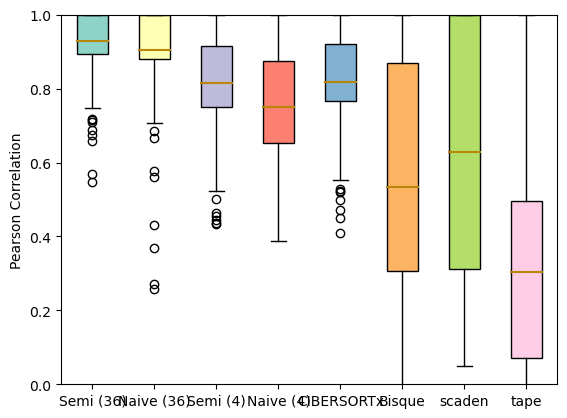

In [232]:
fig, ax = plt.subplots()
meanlineprops = dict(linestyle='-', linewidth=1.5, color='darkgoldenrod')

# Plot the boxplots
boxplot = ax.boxplot([pcors, naivecors, pcors4, naivecors4, cibercors, biscor,scadencors,tapecor], patch_artist=True,showmeans = True, meanline=True, meanprops=meanlineprops)
# Define the colors for the boxes
box_colors = mcp.gen_color(cmap="Set3",n=6)
box_colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']
set3 = plt.get_cmap('Set3')
box_colors = set3.colors
# Iterate over each box and set the facecolor
for box, color in zip(boxplot['boxes'], box_colors):
    box.set(facecolor=color)

    
for median in boxplot['medians']:
    median.set_color('none')  
    
# Add axis labels and title
#ax.set_xlabel('Method')
ax.set_ylabel('Pearson Correlation')
#ax.set_title('Deconvolution Performance Comparison')

# Add x-axis tick labels
ax.set_xticklabels(['Semi (36)', 'Naive (36)', 'Semi (4)', 'Naive (4)','CIBERSORTx','Bisque','scaden','tape'])
ax.set_ylim(0,1)
# Display the plot
plt.savefig('results/1111deconv_pcorr .pdf')
plt.show()


In [226]:
## wilcox for rmse

# between semi 4 patients and CIBERSORTx
r_semi4_ciber = wilcoxon(x=prmses4, y=ciberrmses, alternative='less')
print('between semi 4 and CIBERSORTx',r_semi4_ciber.statistic, r_semi4_ciber.pvalue)

# between semi 28 and naive 28
r_semi28_naive28 = wilcoxon(x=prmses, y=naivermse, alternative='less')
print('between semi 28 and naive 28',r_semi28_naive28.statistic, r_semi28_naive28.pvalue)

# between semi 4 and naivee 4
r_semi4_naive4 = wilcoxon(x=prmses4, y=naivermse4, alternative='less')
print('between semi 4 and naive 4',r_semi4_naive4.statistic, r_semi4_naive4.pvalue)

# between semi 28 and semi 4
r_semi28_semi4 = wilcoxon(x=prmses, y=prmses4, alternative='less')
print('between semi 28 and semi 4',r_semi28_semi4.statistic, r_semi28_semi4.pvalue)

# between semi 4 and bisque
r_semi4_bisque = wilcoxon(x=prmses4, y=bisrmse, alternative='less')
print('between semi 4 and bisque',r_semi4_bisque.statistic, r_semi4_bisque.pvalue)

# between semi 28 and sesmi 4
r_semi28_semi4 = wilcoxon(x=prmses, y=prmses4, alternative='less')
print('between semi 28 and semi 4',r_semi28_semi4.statistic, r_semi28_semi4.pvalue)

res = wilcoxon(x=prmses4, y=tapermse, alternative='less')
print('between semi 4 and tape',res.statistic, res.pvalue)

res = wilcoxon(x=prmses4, y=scadenrmses, alternative='less')
print('between semi 4 and scaden',res.statistic, res.pvalue)


between semi 4 and CIBERSORTx 2401.0 0.04832589523064194
between semi 28 and naive 28 260.0 6.233920399526485e-10
between semi 4 and naive 4 864.0 9.302779124104528e-11
between semi 28 and semi 4 307.0 3.2459199567312037e-16
between semi 4 and bisque 573.0 1.8736685041079586e-13
between semi 28 and semi 4 307.0 3.2459199567312037e-16
between semi 4 and tape 573.0 1.8736685041079586e-13
between semi 4 and scaden 2521.0 0.09792081887064802


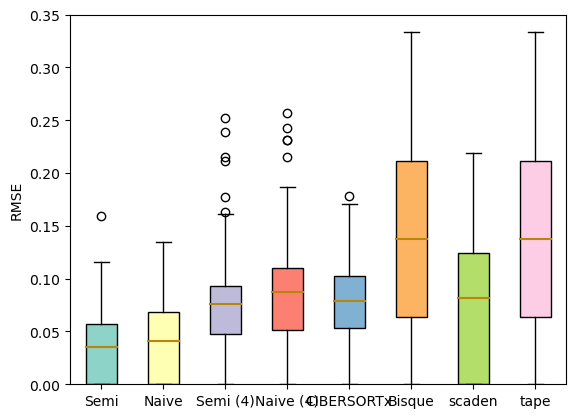

In [233]:
fig, ax = plt.subplots()
meanlineprops = dict(linestyle='-', linewidth=1.5, color='darkgoldenrod')

# Plot the boxplots
boxplot = ax.boxplot([prmses, naivermse, prmses4, naivermse4, ciberrmses, bisrmse,scadenrmses,tapermse], patch_artist=True,showmeans = True, meanline=True, meanprops=meanlineprops)

for median in boxplot['medians']:
    median.set_color('none')  

# Define the colors for the boxes
'''box_colors = ['#a6cee3',
 '#1f78b4',scandenrmse
 '#b2df8a',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']'''
#['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']

box_colors = set3.colors

# Iterate over each box and set the facecolor
for box, color in zip(boxplot['boxes'], box_colors):
    box.set(facecolor=color)

# Add axis labels and title
#ax.set_xlabel('Method')
ax.set_ylabel('RMSE')
#ax.set_title('Deconvolution Performance Comparison')

# Add x-axis tick labels
ax.set_xticklabels(['Semi', 'Naive', 'Semi (4)', 'Naive (4)','CIBERSORTx','Bisque','scaden','tape'])
ax.set_ylim(0,0.35)
# Display the plot
plt.savefig('results/1111deconv_rmse.pdf')
plt.show()

In [173]:
len(df.columns)

110